29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2089 - loss: 2.3697 - val_accuracy: 0.6550 - val_loss: 1.2506
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6298 - loss: 1.1802 - val_accuracy: 0.6750 - val_loss: 0.9356
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7355 - loss: 0.8685 - val_accuracy: 0.7300 - val_loss: 0.8246
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8097 - loss: 0.6726 - val_accuracy: 0.7100 - val_loss: 0.7414
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.5738 - val_accuracy: 0.7650 - val_loss: 0.6967

Adversarially Trained Model Accuracy: 76.50%

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2046 - loss: 4.2405 - val_accuracy: 0.4800 - val_loss: 2.2652
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4948 - loss: 2.1648 - val_accuracy: 0.6050 - val_loss: 1.5351
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6020 - loss: 1

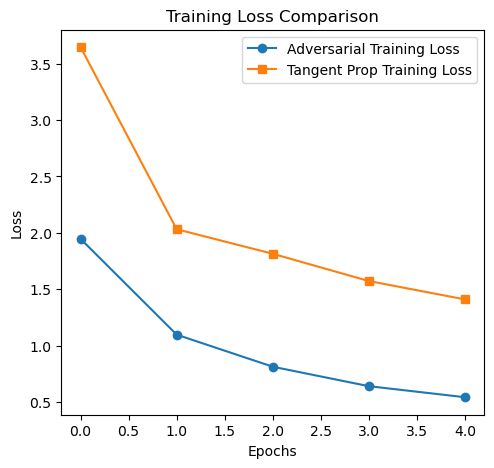

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Layer
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
subset_size = 1000
x_train = x_train[:subset_size].astype("float32") / 255.0
y_train = y_train[:subset_size]
x_test = x_test[:200].astype("float32") / 255.0
y_test = y_test[:200]

def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(64, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def generate_adversarial_examples(model, x, y, epsilon=0.1):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, predictions)
    gradients = tape.gradient(loss, x_tensor)
    signed_grad = tf.sign(gradients)
    x_adv = x_tensor + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv.numpy()

model_adv = create_model()
x_adv = generate_adversarial_examples(model_adv, x_train, y_train, epsilon=0.1)
x_combined = np.concatenate([x_train, x_adv], axis=0)
y_combined = np.concatenate([y_train, y_train], axis=0)

history_adv = model_adv.fit(x_combined, y_combined, epochs=5, batch_size=64, validation_data=(x_test, y_test), verbose=1)

loss_adv, accuracy_adv = model_adv.evaluate(x_test, y_test, verbose=0)
print(f"\nAdversarially Trained Model Accuracy: {accuracy_adv * 100:.2f}%")


class TangentProp(Layer):
    def call(self, x):
        perturbation = tf.random.normal(shape=tf.shape(x), stddev=0.1)
        return x + perturbation



model_tangent_prop = create_model()
model_tangent_prop.add(TangentProp())

history_tangent_prop = model_tangent_prop.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_test, y_test),
    verbose=1
)

loss_tangent_prop, accuracy_tangent_prop = model_tangent_prop.evaluate(x_test, y_test, verbose=0)
print(f"\nAdversarially Trained Model with Tangent Prop Accuracy: {accuracy_tangent_prop * 100:.2f}%")


def tangent_distance(x1, x2):
    return np.linalg.norm(x1 - x2)


def classify_with_tangent_distance(x_train, y_train, x_test):
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)
    y_pred = []

    print(f"\nClassifying {len(x_test_flat)} test samples...")

    for i, test_sample in enumerate(x_test_flat):
        if (i + 1) % 20 == 0:
            print(f"Progress: {i + 1}/{len(x_test_flat)}")

        distances = [tangent_distance(test_sample, train_sample) for train_sample in x_train_flat]
        nearest_index = np.argmin(distances)
        y_pred.append(y_train[nearest_index])

    return np.array(y_pred)


y_pred_tangent = classify_with_tangent_distance(x_train, y_train, x_test)

accuracy_tangent = np.mean(y_pred_tangent == y_test)
print(f"\nTangent Distance Classifier Accuracy: {accuracy_tangent * 100:.2f}%")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_adv.history['loss'], label='Adversarial Training Loss', marker='o')
plt.plot(history_tangent_prop.history['loss'], label='Tangent Prop Training Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()